In [1]:
#논문: https://arxiv.org/abs/1706.03762
#코드 참고: https://wikidocs.net/31379

import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


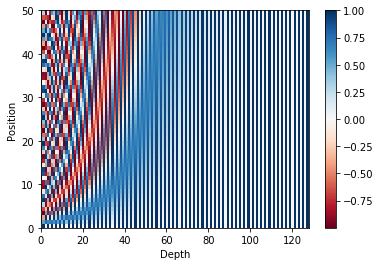

In [3]:
# 문장의 길이 50, 임베딩 벡터의 차원 128
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [4]:
def scaled_dot_product_attention(Q, K, V, mask): 
    ret = tf.matmul(Q, K, transpose_b = True) 
    depth = tf.cast(tf.shape(K)[-1], tf.float32) 
    ret /= tf.math.sqrt(depth) 
    ret = tf.nn.softmax(ret, axis = -1) 
    
    # Padding Mask
    
    #역할 1
    #어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    #입력 문장에 <PAD> 토큰이 있을 경우 어텐션에서 사실상 제외하기 위한 연산
    
    #역할 2
    # look-ahead masking을 처리. 
    # 이전 단어들만 참고하도록.
    if mask is not None: 
        ret += (mask * -1e9) 
    
    attention_weight = ret 
    ret = tf.matmul(ret, V) 
    return ret, attention_weight

In [5]:
class multi_head_attention(tf.keras.layers.Layer):     
    def __init__(self, d_model, num_heads, name = "multi_head_attention"):         
        super(multi_head_attention, self).__init__(name=name)         
        self.num_heads = num_heads         
        self.d_model = d_model                  
        
        assert d_model % self.num_heads == 0                  
        #For each of these we use dk = dv = dmodel/h = 64         
        
        self.depth = d_model // self.num_heads                  
        
        #the projections are parameter matrices W Q i ∈ R dmodel×dk , W K i ∈ R dmodel×dk , WV i ∈ R dmodel×dv and WO ∈ R hdv×dmodel         
        #WQ, WK, WV에 해당하는 밀집층 정의         
        self.query_dense = tf.keras.layers.Dense(units=d_model)         
        self.key_dense = tf.keras.layers.Dense(units=d_model)         
        self.value_dense = tf.keras.layers.Dense(units=d_model)                  
        
        self.dense = tf.keras.layers.Dense(units=d_model)              
        
    #head 개수만큼 WQ, WK, WV를 split     
    def split_heads(self, inputs, batch_size):         
        inputs = tf.reshape(             
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))         
        return tf.transpose(inputs, perm=[0, 2, 1, 3])       # where is it from ?
    
    def call(self, inputs): 
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask'] 
        batch_size = tf.shape(query)[0]
        
        query = self.query_dense(query) 
        key = self.key_dense(key) 
        value = self.value_dense(value) 
        
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        
        #headi = Attention(QWQ i , KW K i , V WV i ) 
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3]) 
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        #WO 곱하기 (Concat(head1, ..., headh) * WO)
        # = WO에 해당하는 밀집층 지나기
        outputs = self.dense(concat_attention)
        
        return outputs
        

In [6]:
#입력된 정수 시퀀스에서 패딩 토큰의 인덱스인지, 아닌지를 판별하기 위해
#정수 시퀀스에서 0인 경우에는 1로 변환하고, 
#그렇지 않은 경우에는 0으로 변환하는 함수

#이 함수를 통해 1의 값을 가진 위치의 열을 
#어텐션 스코어 행렬에서 마스킹하는 용도로 사용할 수 있고
#이를 스케일드 닷 프로덕트 어텐션의 인자로 전달하면, 
#스케일드 닷 프로덕트 어텐션에서는 이 벡터에다가 매우 작은 음수값인 -1e9를 곱하고, 
#이를 행렬에 더해주어 해당 열을 전부 마스킹한다.

def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    
    return mask[:, tf.newaxis, tf.newaxis, :]

print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


In [7]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name = "inputs")
    
    #padding mask on encoder
    padding_mask = tf.keras.Input(shape = (1, 1, None), name="padding_mask")
    
    attention = multi_head_attention(d_model, num_heads, name = "attention")(
    {
        "query": inputs, "key" : inputs, "value" : inputs,
        "mask" : padding_mask
    })

    #add(H(x) = x + F(x)) & normalize
    
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(inputs + attention)
    
    #position-wise feed forward network
    outputs = tf.keras.layers.Dense(units = dff, activation = 'relu')(attention)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)
    
    #add & norm
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention+outputs)
    
    return tf.keras.Model(inputs = [inputs, padding_mask], outputs = outputs, name = name)
    

In [8]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name = "encoder"):
    inputs = tf.keras.Input(shape = (None, ), name ="inputs")
    
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = "padding_mask")
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate = dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [9]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    
    
    return tf.maximum(look_ahead_mask, padding_mask)

In [10]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [11]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    
    inputs = tf.keras.Input(shape=(None, d_model), name = "inputs")
    
    #두번째 서브층에 key, value로서 들어가는 encoder에서 나온 stack
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    
    #Encoder의 padding mask에서는 (1, 1, None)이었음
    
    #첫번째 서브층
    look_ahead_mask = tf.keras.Input(shape = (1, None, None), name="look_ahead_mask")
    
    #두번째 서브층
    padding_mask = tf.keras.Input(shape = (1, 1, None), name="padding_mask")
    
    
    #첫번째 서브층(masked multi head attention)
    attention1 = multi_head_attention(d_model, num_heads, name = "attention_1")(
    {
        "query": inputs, "key" : inputs, "value" : inputs,
        "mask" : look_ahead_mask
    })

    #add(H(x) = x + F(x)) & normalize
    
    #여기선 dropout 안하네
    attention1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention1 + inputs)
    
    #두번째 서브층 (multi-head attention)
    attention2 = multi_head_attention(d_model, num_heads, name = "attention_2")(
    {
        "query": attention1, "key" : enc_outputs, "value" : enc_outputs, # Q != K = V
        "mask" : padding_mask
    })

    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [12]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [13]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="transformer"):

    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [14]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

(1, 9000, 128)
(1, 9000, 128)
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [15]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [16]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

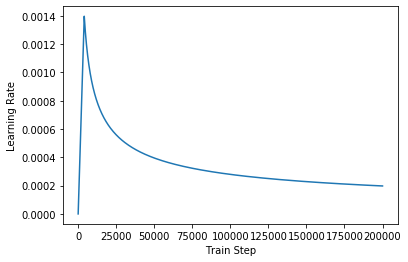

In [17]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")